In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import warnings
from scipy import spatial
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def calculate_RAM(dim_x,dim_y):
  n = np.zeros((dim_x,dim_y))
  z = (n.size * n.itemsize)
  print('Matrix takes: ',z/1000000000,'GB RAM')

In [0]:
def test_cosine():
  # Calculations done on the array in the excel spreadsheet.
  test_arr = np.array([[0,1,1,5,1,0],[1,1,1,5,1,0]])
  n_clusters = 6
  print(test_arr) # Our excel data

  # Column vector with row sums of ratings. 
  row_sums = np.sum(test_arr,axis=1)
  print(row_sums)

  # Column vector with row sums / N clusters
  inter_mediate = row_sums / len(test_arr[0])
  print(inter_mediate)
  
  # Subtraction
  # Subtract the column vector with row sums / N clusters from
  # Our ratings matrix. 
  test_arr = test_arr - inter_mediate[:,None]
  print(test_arr)
  
  #Sum of squares
  ssq = np.sum(test_arr**2, axis=1)
  print(ssq)
  
  #Squared sum of squares
  ssq = np.sqrt(ssq)
  print(ssq)

  # last step. A_k * B_k / squared sum of squares A, ssq B. 
  cd = np.sum(np.prod(test_arr,axis=0))/np.prod(ssq)
  print('our cosine similarty is', cd)

  # Test it using Library
  result = 1 - spatial.distance.cosine(test_arr[0], test_arr[1])
  assert cd == result

  print('distance matrix')
  dist_out = 1-pairwise_distances(test_arr, metric="cosine")
  print(dist_out)

In [0]:
def get_distance_matrix(matrix):

  # Calculations done on sliced utility matrix

  # create column vector which has row sums of ratings. 
  row_sums = np.sum(matrix,axis=1)

  #create intermediate column vector with rating sum / N clusters 
  inter_mediate = row_sums / matrix.shape[1]

  # Take away the rating_sum / N clusters column vector 
  # from the sliced matrix
  matrix = matrix - inter_mediate[:,None]

  # Generate distance matrix using Sklearn library out of
  # The normalised matrix.  
  dist_out = 1-pairwise_distances(matrix, metric="cosine")
  return dist_out

In [0]:
train = pd.read_csv('drive/My Drive/Data_mining/1percent.csv')
print('number of rows in sample', len(train))
train.drop(columns=['date_time'],inplace=True)

number of rows in sample 376703


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
train.head(3)

,Unnamed: 0,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,3759409,2,3,181,238,14762,NaN,137728,0,1,9,2014-11-16,2014-11-19,2,1,1,8747,1,0,1,3,106,107,89
1,24267012,2,3,66,174,3968,2263.7652,614586,0,0,9,2014-09-11,2014-09-14,4,0,1,17520,3,0,1,2,50,682,0
2,12893449,2,3,66,356,22202,9232.4460,1116495,0,0,9,2014-11-18,2014-11-21,1,0,1,8807,1,0,3,0,63,1193,46


In [0]:
col_list = ['user_id','hotel_cluster','is_booking', 'srch_destination_id']
subset_data = train[col_list]
subset_data['rating'] = pd.Series(dtype=float)

In [0]:
subset_data.sort_values(by=['user_id'],inplace=True)

#Create User - Item Matrix out of User-ID's and Rankings. 

In the later experiments, we will use user ID representing user; and hotel cluster repre- senting item. When a hotel cluster is viewed by a user, rating of 1 is given; when a hotel is booked, rating of 5 is given.

In [0]:
# First some statistics on user_id and hotel clusters.
subset_data['user_id'].nunique() # out of 376703 ids, 262231 are unique. 

262231

In [0]:
# Test: find all hotel clusters clicked by user_id 137728. 
z = subset_data[subset_data['user_id']==137728]
print(z)

        user_id  hotel_cluster  is_booking  srch_destination_id  rating
105418   137728             65           0                11439     NaN
0        137728             89           0                 8747     NaN
3461     137728             64           0                 8282     NaN


In [0]:
subset_data.head(5) # Our data is sorted. 

,user_id,hotel_cluster,is_booking,srch_destination_id,rating
205210,9,99,0,12227,NaN
291780,13,15,0,8255,NaN
57853,13,59,0,8255,NaN
164574,13,29,0,8255,NaN
16570,13,64,0,11816,NaN


In [0]:
c = subset_data[subset_data['is_booking'] ==1]
print(len(c)) #number of bookings. 

30270


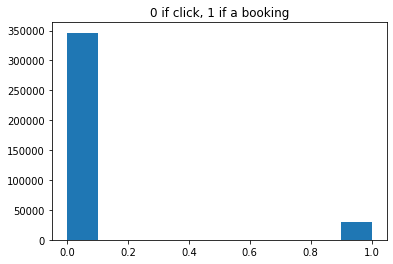

In [0]:
plt.figure()
plt.hist(subset_data['is_booking'])
plt.title('0 if click, 1 if a booking')
plt.show()

In [0]:
# Where booking == 1, give rating 5 otherwise give rating 1. 
subset_data['rating'] = np.where((subset_data['is_booking']==1),5,1)

In [0]:
# lets test our approach on first twenty rows. 
data_matrix = subset_data.iloc[:,[0,1,4]]
print(data_matrix.head(5))
data_matrix = data_matrix.to_numpy()

        user_id  hotel_cluster  rating
205210        9             99       1
291780       13             15       1
57853        13             59       1
164574       13             29       1
16570        13             64       1


In [0]:
subset_data.head(5)

,user_id,hotel_cluster,is_booking,srch_destination_id,rating
205210,9,99,0,12227,1
291780,13,15,0,8255,1
57853,13,59,0,8255,1
164574,13,29,0,8255,1
16570,13,64,0,11816,1


In [0]:
#Print first 10 rows of data_matrix.
data_matrix[0:10,:]

array([[ 9, 99,  1],
       [13, 15,  1],
       [13, 59,  1],
       [13, 29,  1],
       [13, 64,  1],
       [33, 79,  1],
       [36, 68,  1],
       [40, 23,  1],
       [56, 44,  1],
       [79, 52,  1]])

In [0]:
last_user_id =subset_data.iloc[-1].user_id # 1198777 # Last user_id.
print('last user id is', last_user_id)
utility_matrix = np.zeros(dtype=int,shape=(last_user_id+1,100))
print('our utility matrix has shape', utility_matrix.shape)

last user id is 1198777
our utility matrix has shape (1198778, 100)


In [0]:
#Fill the utility matrix. 
# Add data_matrix[:,2] list of ratings to X and Y coordinates denoted in X. 
# Takes around 20 seconds
x = [data_matrix[:,0], data_matrix[:,1]] 
np.add.at(utility_matrix,x,data_matrix[:,2])
np.savetxt("foo.csv", utility_matrix, delimiter=",")

In [0]:
calculate_RAM(utility_matrix.shape[0],utility_matrix.shape[1])

Matrix takes:  0.9590224 GB RAM


## Normalisation of matrix. 

In [0]:
test_cosine()

[[0 1 1 5 1 0]
 [1 1 1 5 1 0]]
[8 9]
[1.33333333 1.5       ]
[[-1.33333333 -0.33333333 -0.33333333  3.66666667 -0.33333333 -1.33333333]
 [-0.5        -0.5        -0.5         3.5        -0.5        -1.5       ]]
[17.33333333 15.5       ]
[4.163332   3.93700394]
our cosine similarty is 0.9761422017385009
distance matrix
[[1.        0.9761422]
 [0.9761422 1.       ]]


In [0]:
# Perform the operation on first 1000 rows yet, 
# Due to ram Limitations
sliced_matrix = utility_matrix[0:1000,:]
do = get_distance_matrix(sliced_matrix)


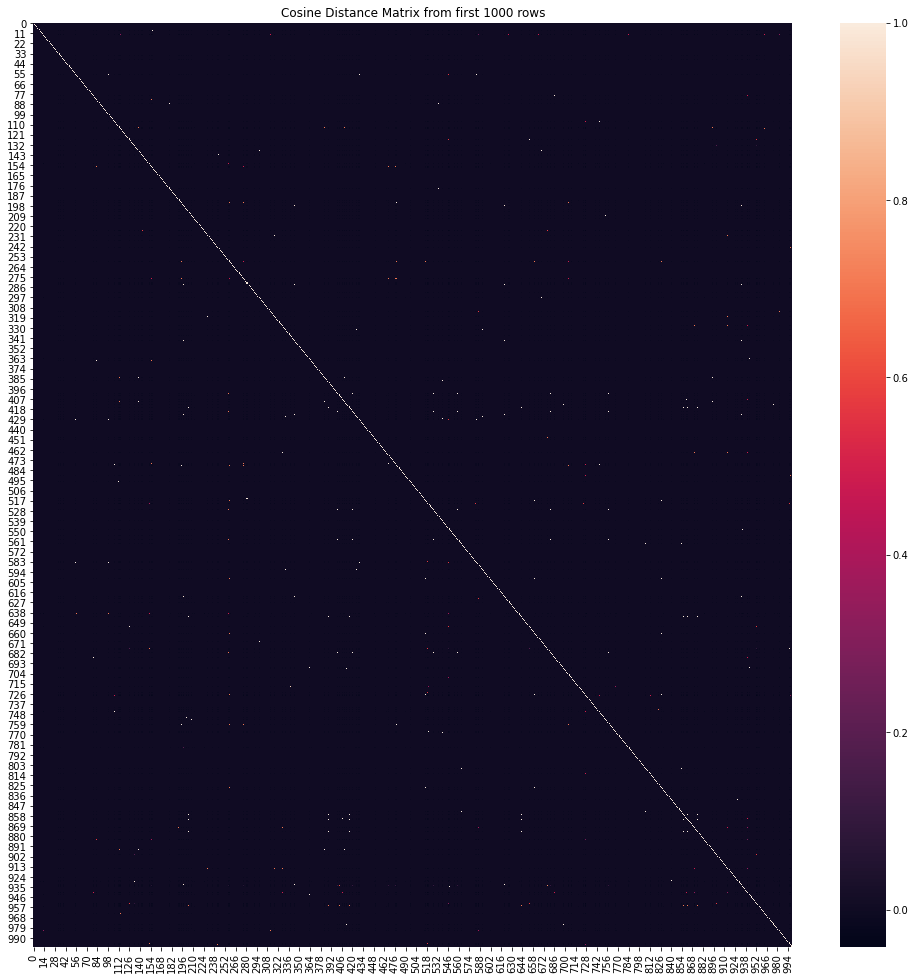

In [0]:
plt.figure(figsize=(17,17))
sns.heatmap(do)
plt.title('Cosine Distance Matrix from first 1000 rows')
plt.show()

# Clustering Users based on Distance Matrix

In [0]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

Z = linkage(do, 'ward')
print(Z)


[[9.00000000e+00 1.57000000e+02 0.00000000e+00 2.00000000e+00]
 [8.41000000e+02 9.28000000e+02 1.57009246e-16 2.00000000e+00]
 [2.30000000e+02 3.18000000e+02 1.57009246e-16 2.00000000e+00]
 ...
 [1.06300000e+03 1.99500000e+03 8.44653916e+00 9.85000000e+02]
 [1.08600000e+03 1.99600000e+03 9.22581667e+00 9.92000000e+02]
 [1.94600000e+03 1.99700000e+03 1.06159735e+01 1.00000000e+03]]


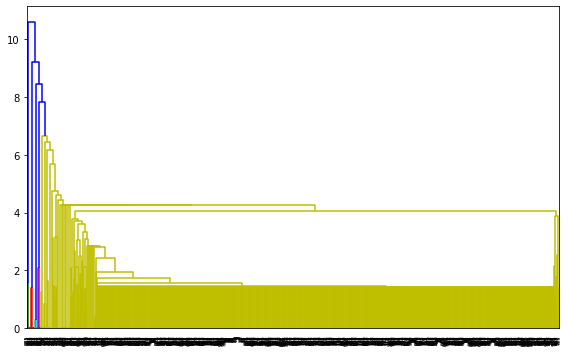

In [0]:
fig, ax = plt.subplots(figsize=(8, 5)) # set size
ax = dendrogram(Z, orientation="top",show_leaf_counts=True);

### Visualising it is pretty useless
plt.tick_params(
    axis= 'y',          # changes apply to the x-axis
    which='off',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

In [0]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=112,affinity='euclidean', linkage='ward')

### The clusters assigned to user proiles
clusters = cluster.fit_predict(do)


In [0]:
test = subset_data.copy(deep=True)

In [0]:
## Mappin user clusters back to dataframed
def add_clusters_to_frame(or_data, clusters):
    or_frame = pd.DataFrame(data=or_data)
    or_frame_labelled = pd.concat([or_frame, pd.DataFrame(clusters)], axis=1)
    return(or_frame_labelled)

df = add_clusters_to_frame(test, clusters)

df.head(30)


,user_id,hotel_cluster,is_booking,srch_destination_id,rating,0
0,137728,89,0,8747,1,86.0
1,614586,0,0,17520,1,86.0
2,1116495,46,0,8807,1,86.0
3,278958,57,0,18569,1,86.0
4,740919,90,0,18998,1,86.0
5,398779,33,0,24946,1,86.0
6,611721,13,0,12191,1,86.0
7,76900,4,0,11827,1,86.0
8,415427,94,0,27717,1,86.0
9,556564,5,0,27967,1,29.0


#Remaking utility matrix and SVD

In [0]:
from numpy.linalg import matrix_rank
import torch
# So far, we have 
# 1.) utility_matrix - user_id x hotel_cluter
# 2.) clusters for every user_id
# print(sliced_matrix[0:10, :])

# We need to compress utility matrix by replacing user_id with user_cluster
# and remove all rows where user_cluster repeats

# returns rows andices of rows where are unique user_clusters

unique_clusters = np.unique(clusters, return_index=True)
# create matrix user_cluster x hotel_cluster
clustered_matrix = sliced_matrix[unique_clusters[1]]


# counts nuber of rows, where are different user_clusters with same hotel_cluster values
# ?? we should avoid to have two user_clusters with same hotel_cluster values
# print(np.unique(clustered_matrix, axis=0, return_counts=True)[1])

def sgd(M,rank,num_epochs,lr,lamda):
  # n: number of user_clusters (112)
  n=M.shape[0]
  # k: number of hotel_clusters (100)
  k=M.shape[1]
  # Define U and V
  U=torch.rand(n,rank)
  V=torch.rand(k,rank)

  for epoch in range(num_epochs):
    for r in range(n):
      for c in range(k):
        # We are updating U and V for every known value. 
        if M[r][c]>0:  
          e1=M[r][c]-V[c,:].t()@U[r,:]
          e2=M[r][c]-U[r,:].t()@V[c,:]
          U[r,:]=U[r,:]+lr*(e1*V[c,:]-lamda*U[r,:])
          V[c,:]=V[c,:]+lr*(e2*U[r,:]-lamda*V[c,:])
  return U,V

#  Find the rank of the cluster Matrix.
rank=matrix_rank(clustered_matrix)

U,V=sgd(clustered_matrix,rank,1000,0.01,0.01)
print(U.shape)
print(V.shape)


torch.Size([112, 70])
torch.Size([100, 70])


In [0]:
def svd(U,V,M):
  n=M.shape[0]
  k=M.shape[1]
  new_M = np.zeros([n,k])
  for r in range(n): 
    for c in range(k):
      new_M[r][c]=U[r,:]@V[c,:].T
  return new_M

new_clustered=svd(U,V,clustered_matrix)
print(new_clustered)


[[ 8.07887268  6.27086163 11.64339066 ... 11.94241238 12.36885262
   6.95656252]
 [ 6.59058475  6.97591972 10.43289661 ...  9.89057732  9.94933128
   5.81643391]
 [ 9.01297188  8.05379105 11.58332825 ... 11.14805794 12.55107498
   5.76701546]
 ...
 [ 2.6145246   1.65842652  3.51151919 ...  2.71439934  4.60982513
   2.05827403]
 [ 8.74667835  7.06621981 11.01608658 ... 11.99051666 12.78038788
   6.48054123]
 [ 3.5866189   2.39013934  3.85897541 ...  5.91353798  4.83666325
   4.43325901]]


# Combination

Creating D matrix, which is (srch_destination_id x hotel_cluster):

In [0]:
# remove is_booking column which is no more needed
subset_data = subset_data.iloc[:, [0, 1, 3, 4]]
#  sort by srch_destination_in
subset_data.sort_values(by=['srch_destination_id'], inplace=True)

np_subset_matrix = np.array(subset_data)

#orig_matrix = np.array([[0, 0, 0, 0], [1, 1, 1, 1], [2, 1, 5, 1], [3, 1, 5, 3], [4, 0, 1, 1], [5, 2, 0, 2]])

last_dest_id = np_subset_matrix[-1, 2]
n_hotel_clusters = 100

# empty D matrix: (n of destinations x n of hotel clusters)
# !!! destination_ids start with index 0 (e.i. dest_id 1 is at position 0) !!!
destination_matrix = np.zeros([last_dest_id, n_hotel_clusters])

In [0]:
# calculate part of destination matrix for each hotel cluster separately
for i in range(n_hotel_clusters):
    # create filtered_matrix only with rows where hotel cluster == i
    indices_to_filter = np.where(np_subset_matrix[:, 1] == i)
    filtered_matrix = np_subset_matrix[indices_to_filter]

    # if there are no values for looped hotel_cluster, then go to next iteration
    if len(filtered_matrix) == 0:
        continue
    # create matrix with ratings only
    rank_matrix = filtered_matrix[:, 3]

    # group by destination and sum all ratings for each destination
    d = np.diff(filtered_matrix[:, -2])
    d = np.where(d)[0]
    indices = np.r_[0, d + 1]
    # summed all ratings for each destination
    summed_rating = np.add.reduceat(rank_matrix, indices, axis=0)

    # get number of ratings for each destination
    np_counts = np.array(np.unique(filtered_matrix[:, 2], return_counts=True))
    # transpose matrix to get values by columns
    # destination_ids of all destinations used
    destination_ids = np_counts.T[:, 0]
    # number of times one hotel_cluster has been rated in one  destination_id
    count_values = np_counts.T[:, 1]

    # calculate average rating for each destination
    average = np.divide(summed_rating, count_values)

    # fill destination matrix with average values
    # shift each destination_id in matrix by one to start from index 0
    destination_matrix[destination_ids - 1, i] = average

print(destination_matrix[:10])


[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   

Create Matrix R = M x D

In [0]:
matrix_r = new_clustered.dot(destination_matrix.T)

new_clustered.shape
destination_matrix.shape

# Matrix R has shape n_of_user_clusters x n_of_destination_ids
print(matrix_r.shape)

(112, 65035)


Find best hotel_cluster for given user_cluster

In [0]:
selected_user_cluster = 1

# find best destination_id for given user_cluster
sel_row = matrix_r[selected_user_cluster]
top_destination_id = np.argsort(-sel_row)[0]

# find best hotel_cluster for given destination_id
sel_dest_row = destination_matrix[top_destination_id]
top_5_h_clusters = np.argsort(-sel_dest_row)[:5]

# print 5 best matches for given user_cluster
print('for user_cluster {}, best hotel_clusters are {}'.format(selected_user_cluster, top_5_h_clusters))

for user_cluster 1, best hotel_clusters are [67 62 32 53 33]


# Decision Tree Classifier for Unseen Users


In [0]:
## Defining User Profile Features ##
user_profile_features = ["user_id","site_name","posa_continent",
                         "user_location_country","user_location_region",
                         "user_location_city",
                         "is_mobile","is_package",
                         "channel"]

In [0]:
## Filtering data on user profile features ##
users_data = train.filter(user_profile_features)
users_data.head()

,user_id,site_name,posa_continent,user_location_country,user_location_region,user_location_city,is_mobile,is_package,channel
0,137728,2,3,181,238,14762,0,1,9
1,614586,2,3,66,174,3968,0,0,9
2,1116495,2,3,66,356,22202,0,0,9
3,278958,2,3,66,356,22202,0,1,9
4,740919,37,1,69,574,28513,1,1,9


In [0]:
## Adding dummy clusters, this step is not necessary when we have the real clusters data ##
import random
import time
clusters_dummy = []

for i in range(users_data.shape[0]):
    random.seed(time.time())
    clusters_dummy.append(random.randint(0, 3))

users_data["user_cluster"] = clusters_dummy
users_data.head()

,user_id,site_name,posa_continent,user_location_country,user_location_region,user_location_city,is_mobile,is_package,channel,user_cluster
0,137728,2,3,181,238,14762,0,1,9,0
1,614586,2,3,66,174,3968,0,0,9,0
2,1116495,2,3,66,356,22202,0,0,9,3
3,278958,2,3,66,356,22202,0,1,9,0
4,740919,37,1,69,574,28513,1,1,9,0


In [0]:
#################### Decision Tree Classifier ####################
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

### Features ###
X = users_data.iloc[:,1:-1]

### Target Variable ###
Y = users_data.iloc[:,-1]
X.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,is_mobile,is_package,channel
0,2,3,181,238,14762,0,1,9
1,2,3,66,174,3968,0,0,9
2,2,3,66,356,22202,0,0,9
3,2,3,66,356,22202,0,1,9
4,37,1,69,574,28513,1,1,9


In [0]:
### Splitting the data ###
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

In [0]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X=X_train, y=y_train)

tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_)

0.2524273125106621 {'max_depth': 3}


In [0]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.92      0.39     18871
           1       0.00      0.00      0.00     18749
           2       0.27      0.03      0.05     18686
           3       0.27      0.06      0.10     19035

    accuracy                           0.25     75341
   macro avg       0.20      0.25      0.14     75341
weighted avg       0.20      0.25      0.14     75341

